In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api

In [4]:
ctx = api.Context()

In [5]:
ds = ctx.load(
    "raw",
    path="/home/clausen/Data/EMPAD/scan_11_x256_y256.raw",
    dtype="float32",
    scan_size=(256, 256),
    detector_size_raw=(130, 128),
    crop_detector_to=(128, 128),
)

In [6]:
def all_ones():
    return np.ones((128, 128))

In [7]:
def single_pixel():
    buf = np.zeros((128, 128))
    buf[64, 64] = 1
    return buf

In [8]:
job = ctx.create_mask_job(factories=[all_ones, single_pixel], dataset=ds)

In [9]:
%%time
result = ctx.run(job)

CPU times: user 222 ms, sys: 13.2 ms, total: 236 ms
Wall time: 658 ms


<IPython.core.display.Javascript object>


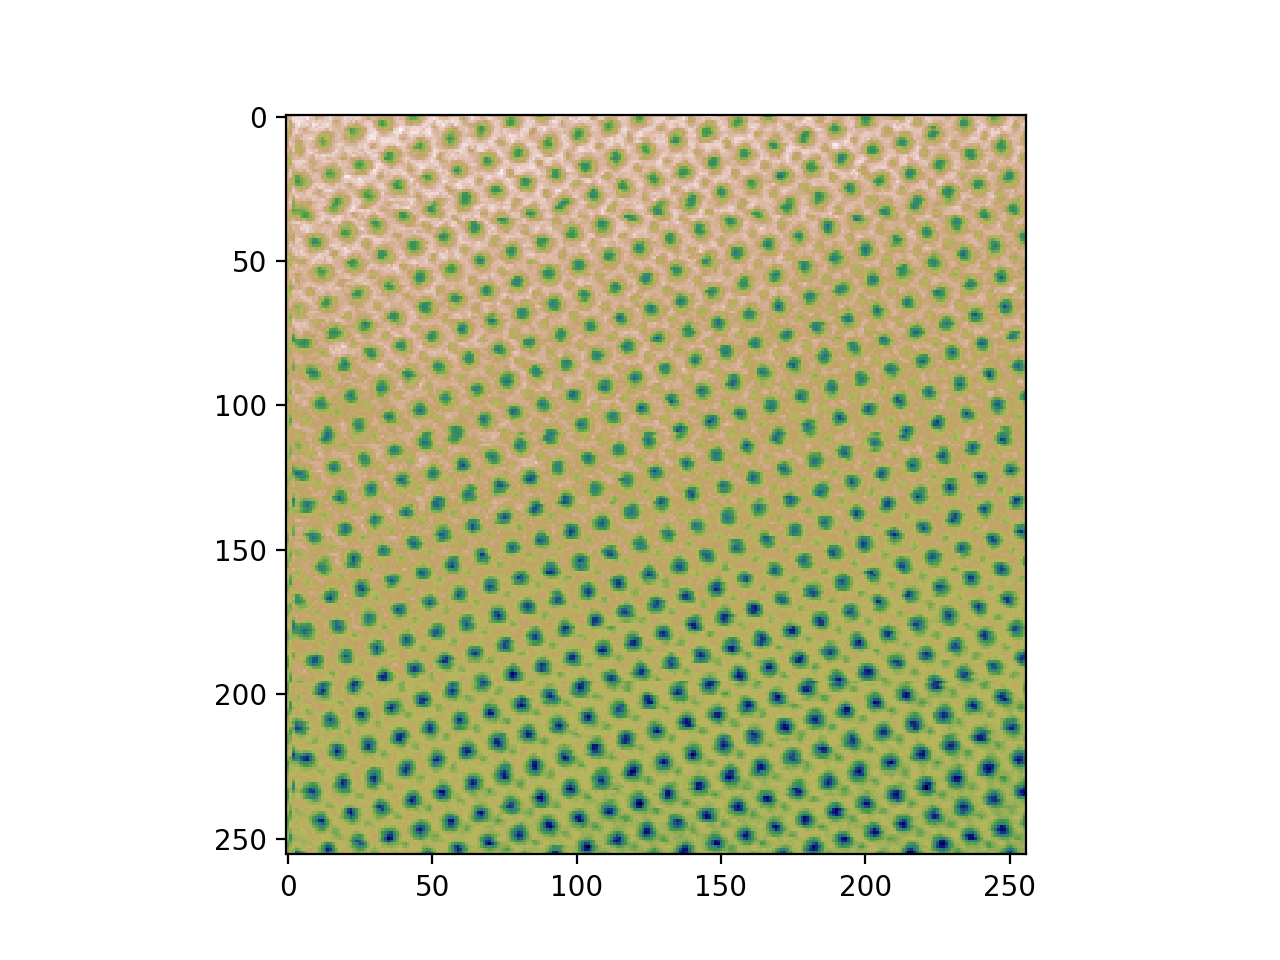

In [10]:
fig, axes = plt.subplots()
axes.imshow(result[0], cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


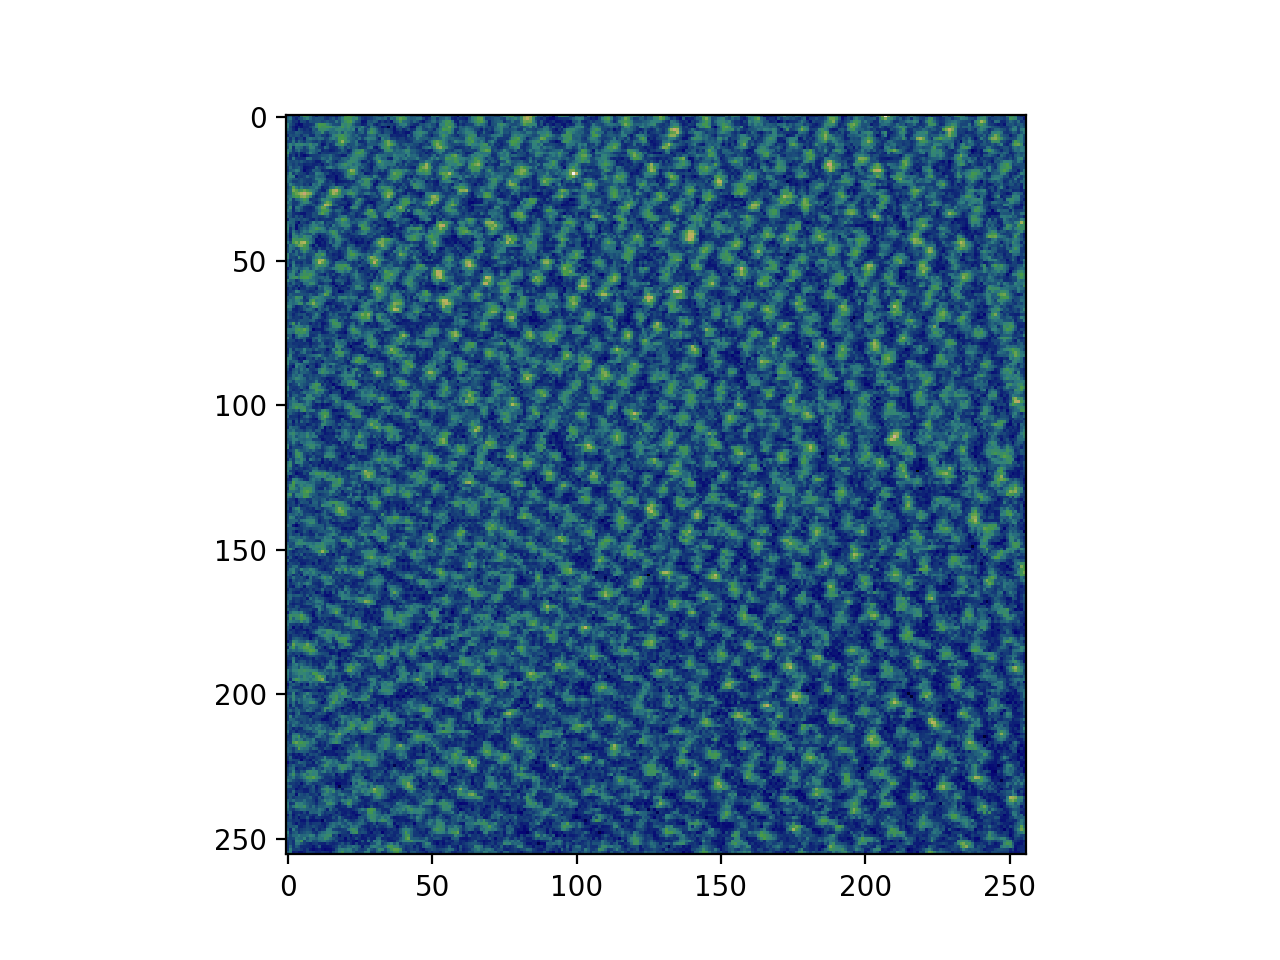

In [11]:
fig, axes = plt.subplots()
axes.imshow(result[1], cmap=cm.gist_earth)